In [19]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import re
from scipy.fftpack import dct, idct
from scipy.optimize import minimize
from sklearn import linear_model
from scipy.stats import pearsonr, spearmanr

sys.path.append(os.path.join('..','UTILS'))
# from cosamp_fn import cosamp
# cosamp function is available at https://github.com/avirmaux/CoSaMP
# copy function from ipynb into cosamp_fn.py and place in UTILS folder

# plt.rcParams['figure.figsize'] = [12, 12]
# plt.rcParams.update({'font.size': 18})

In [5]:
import pandas as pd
import networkx as nx
from sklearn.utils import shuffle
from collections import Counter

from QAOAKit import (
    opt_angles_for_graph,
    get_fixed_angles,
    get_graph_id,
    get_graph_from_id,
    angles_to_qaoa_format,
    beta_to_qaoa_format,
    gamma_to_qaoa_format,
    angles_to_qiskit_format,
    angles_to_qtensor_format,
    get_3_reg_dataset_table,
    get_3_reg_dataset_table_row,
    get_full_qaoa_dataset_table_row,
    get_full_qaoa_dataset_table,
    get_fixed_angle_dataset_table,
    get_fixed_angle_dataset_table_row,
    qaoa_maxcut_energy,
    noisy_qaoa_maxcut_energy,
    angles_from_qiskit_format,

)

from QAOAKit.compressed_sensing import cosamp

In [6]:
def cosamp(phi, u, s, epsilon=1e-10, max_iter=1000):
    """
    Return an `s`-sparse approximation of the target signal
    Input:
        - phi, sampling matrix
        - u, noisy sample vector
        - s, sparsity
    """
    a = np.zeros(phi.shape[1])
    v = u
    it = 0 # count
    halt = False
    while not halt:
        it += 1
        print("Iteration {}\r".format(it), end="")
        
        y = np.dot(np.transpose(phi), v)
        omega = np.argsort(y)[-(2*s):] # large components
        omega = np.union1d(omega, a.nonzero()[0]) # use set instead?
        phiT = phi[:, omega]
        b = np.zeros(phi.shape[1])
        # Solve Least Square
        b[omega], _, _, _ = np.linalg.lstsq(phiT, u)
        
        # Get new estimate
        b[np.argsort(b)[:-s]] = 0
        a = b
        
        # Halt criterion
        v_old = v
        v = u - np.dot(phi, a)

        halt = (np.linalg.norm(v - v_old) < epsilon) or \
            np.linalg.norm(v) < epsilon or \
            it > max_iter
        
    return a

In [7]:
def cnt_opt_by_cs(x: np.ndarray):
    n = x.shape[0]
    xt = np.fft.fft(x) # Fourier transformed signal
    PSD = xt * np.conj(xt) / n # Power spectral density
    p = n // 32 # num. random samples, p = n/32
    perm = np.floor(np.random.rand(p) * n).astype(int)
    y = x[perm]

    # reconstruct
    Psi = dct(np.identity(n)) # Build Psi
    Theta = Psi[perm,:]       # Measure rows of Psi
    s = cosamp(Theta, y, 10, epsilon=1.e-10, max_iter=10) # CS via matching pursuit
    xrecon = idct(s) # reconstruct full signal
    return xrecon

In [5]:
# reg3s = get_3_reg_dataset_table().reset_index()
# len(reg3s)
# print(reg3s.columns)

Index(['pynauty_cert', 'p_max', 'G', 'n', 'C_{true opt}', 'C_fixed', 'C_opt',
       'beta', 'gamma', 'all beta (degenerate optima)',
       'all gamma (degenerate optima)', 'theta'],
      dtype='object')


In [8]:
def vis_rec(x1, x2, y1, perm):
    n = x1.shape[0]
    t = range(n)
    time_window = np.array([1024,1280])/4096
    freq = np.arange(n)
    L = int(np.floor(n/2))


    plt.figure(figsize=(6, 12))
    fig, axs = plt.subplots(1, 2)
    axs = axs.reshape(-1)

    # axs[1].plot(freq[:L],PSD[:L],color='k',linewidth=2)
    # axs[1].set_xlim(0, 1024)
    # axs[1].set_ylim(0, 1200)

    axs[0].plot(t, x1, color='k', linewidth=2)
    # axs[0].plot(perm / n, y1, color='r',marker='x',linewidth=0,ms=12,mew=4)
    # axs[0].set_xlim(time_window[0],time_window[1])
    # axs[0].set_ylim(-2, 2)

    axs[1].plot(t, x2, color='r',linewidth=2)
    # axs[2].set_xlim(time_window[0],time_window[1])
    # axs[2].set_ylim(-2, 2)

    # xtrecon = np.fft.fft(xrecon,n) # computes the (fast) discrete fourier transform
    # PSDrecon = xtrecon * np.conj(xtrecon)/n # Power spectrum (how much power in each freq)

    # axs[3].plot(freq[:L],PSDrecon[:L],color='r',linewidth=2)
    # axs[3].set_xlim(0, 1024)
    # axs[3].set_ylim(0, 1200)

    plt.show()

In [34]:
def check_n_optima(improved_n_optima, ar_miti, ar_unmiti):
    cnt_n_opt_improved = 0
    cnt_ar_unimproved = 0
    cnt_n_opt_unimproved = 0
    cnt_n_opt_decreased = 0

    if improved_n_optima > 4:
        cnt_n_opt_improved += 1
        if ar_miti > ar_unmiti:
            print(f"improved_n_optima: {improved_n_optima}, " 
            f"and meantime AR: {ar_unmiti:.3f} -> {ar_miti:.3f}")
        else:
            cnt_ar_unimproved += 1
    elif improved_n_optima == 1:
        cnt_n_opt_unimproved += 1
    else:
        cnt_n_opt_decreased += 1

    return np.array([
        cnt_n_opt_improved,
        cnt_ar_unimproved,
        cnt_n_opt_unimproved,
        cnt_n_opt_decreased
    ])


def get_n_freqs(x):
    n = x.shape[0]
    n_freqs = 0

    xt = np.fft.fft(x, n) # computes the (fast) discrete fourier transform
    PSD = xt * np.conj(xt) / n # Power spectrum (how much power in each freq)

    n_freqs = np.sum(PSD > 1)
    
    return n_freqs
    

def count_AR():
    # exp_dir = 'figs/cnt_opt_miti/2022-07-18_20:47:26'
    # exp_dir = 'figs/cnt_opt_miti/2022-07-20_14:53:22'
    # exp_dir = 'figs/cnt_opt_miti/2022-07-20_16:00:39' # grid search
    exp_dir = 'figs/cnt_opt_miti/2022-07-23_17:47:35' # compressed sensing
    graph_dirs = os.listdir(exp_dir)

    graph_dir_pattern = f"G(?P<row_id>[0-9]+)_nQ(?P<n_qubits>[0-9]+)_p2"
    reg = re.compile(graph_dir_pattern)

    # cnt_ar_unimproved = 0
    # cnt_n_opt_improved = 0
    # cnt_n_opt_unimproved = 0
    # cnt_n_opt_decreased = 0

    improved_ars = []
    improved_n_opts = []

    n_graphs = len(graph_dirs)

    # rst_df = pd.read_pickle("cnt_opt_miti_df/2022-07-18_20:47:26_cnt_opt_fixed_angles.p")
    # print(rst_df.columns)
    cnter = np.zeros(4)
    for graph_dir in graph_dirs:
        # print(graph_dir)
        reg_match = reg.match(graph_dir)
        reg_dict = reg_match.groupdict()
        
        # data = []
        mitis = []
        unmitis = []
        
        # miti_cnt_opt = 0
        # unmiti_cnt_opt = 0

        # improved_n_optima = 0
        improved_n_optima_recon = 0
        improved_n_optima_recon_2 = 0
        for i in range(4):
            data = np.load(f'{exp_dir}/{graph_dir}/varIdx{i}.npz', allow_pickle=True)
            # data.append(arr)
            mitis.append(data['mitis_recon'])
            unmitis.append(data['unmitis_recon'])
            # mitis = data['mitis']
            # unmitis = data['unmitis']
            # C_opt = reg3s.iloc[row_id]['C_fixed']
            C_opt = data['C_opt'] # all the same for 4 data's
            
            improved_n_optima_recon += data['improved_n_optima_recon']
            # improved_n_optima += data['improved_n_optima']
            improved_n_optima_recon_2 += np.sum(data['mitis_recon'] > data['unmitis_recon'].max())
            assert improved_n_optima_recon == improved_n_optima_recon_2
            # continue

        mitis = np.concatenate(mitis, axis=0)
        unmitis = np.concatenate(unmitis, axis=0)
        # print(len(mitis))
        # print(len(unmitis))
        
        ar_miti = mitis.max() / C_opt
        ar_unmiti = unmitis.max() / C_opt

        improved_ars.append(ar_miti - ar_unmiti)
            

            # row_id = int(reg_dict['row_id'])
            # n_qubits = int(reg_dict['n_qubits'])
        # print(row_id, n_qubits)
        # row = reg3s.iloc[row_id]
        # row = rst_df[rst_df['row_id'] == row_id].iloc[0]

        # assert row['n_qubits'] == n_qubits
        # assert row['p'] == 2


        # mitis=miti_z, unmitis=unmiti_z,
        #     miti_cnt_opt=miti_cnt_opt, unmiti_cnt_opt=unmiti_cnt_opt

            # adjusted_thd = thd / ar_unmiti
            # adjusted_thd = (1 - ar_unmiti) * C_opt
            # print(f"thd: {thd} -> {adjusted_thd}")
            # print(ar_unmiti)
            # miti_cnt_opt = data['miti_cnt_opt']
            # unmiti_cnt_opt = data['unmiti_cnt_opt']
            # print(data['mitis'], data['unmitis'])
            # miti_cnt_opt = np.mean(row['miti_n_opt_list'])
            # unmiti_cnt_opt = np.mean(row['unmiti_n_opt_list'])
            # C_opts = [C_opts for _ in range(len(data['mitis']))]

            # mitis_rec = cnt_opt_by_cs(mitis)
            # unmitis_rec = cnt_opt_by_cs(unmitis)

            # vis_rec(mitis, mitis_rec, None, None)

            
            # miti_cnt_opt += np.sum(np.isclose(mitis_rec, C_opt, atol=adjusted_thd) == True)
            # unmiti_cnt_opt += np.sum(np.isclose(unmitis_rec, C_opt, atol=adjusted_thd) == True)
        
        cnt = check_n_optima(
            improved_n_optima=improved_n_optima_recon,
            ar_miti=ar_miti,
            ar_unmiti=ar_unmiti
        )
        cnter += cnt
        improved_n_opts.append(improved_n_optima_recon)

        # if miti_cnt_opt > unmiti_cnt_opt:
        #     cnt_n_opt_improved += 1
        #     if ar_miti > ar_unmiti:
        #         print(f"n_optima: {unmiti_cnt_opt} -> {miti_cnt_opt}, " 
        #         f"and meantime AR: {ar_unmiti:.3f} -> {ar_miti:.3f}")
        #         continue
        #     else:
        #         cnt_ar_unimproved += 1
        # elif np.isclose(unmiti_cnt_opt, miti_cnt_opt):   
        #     cnt_n_opt_unimproved += 1
        # elif unmiti_cnt_opt < miti_cnt_opt:
        #     cnt_n_opt_decreased += 1
    
    cnt_n_opt_improved = cnter[0]
    cnt_ar_unimproved = cnter[1]
    cnt_n_opt_unimproved = cnter[2]
    cnt_n_opt_decreased = cnter[3]

    print(f"# of graphs that n_optima improves and AR improves (see details above): {cnt_n_opt_improved - cnt_ar_unimproved} / {n_graphs}")
    print(f"# of graphs that n_optima improves but AR does not: {cnt_ar_unimproved} / {n_graphs}")
    print(f"# of graphs that n_optima does not change: {cnt_n_opt_unimproved} / {n_graphs}")
    print(f"# of graphs that n_optima decreases: {cnt_n_opt_decreased} / {n_graphs}")

    # return cnt_n_opt_improved - cnt_ar_unimproved
    
    # print(improved_cnt_n_opts, improved_ars)
    r_p, p_p = pearsonr(improved_n_opts, improved_ars)
    r_s, p_s = spearmanr(improved_n_opts, improved_ars)
    print("")
    
    print("Corelation value between improved n_optima and improved AR:")
    print(f"Pearson : r={r_p:+.5f}\t p={p_p:.5f}\n"
          f"Spearman: r={r_s:+.5f}\t p={p_s:.5f}")
#     print(f"{feature:<25} & {r_p:+.5f} & {p_p:.5f} \\\\")
    return

In [35]:
count_AR()

improved_n_optima: 17, and meantime AR: 0.993 -> 1.028
improved_n_optima: 24, and meantime AR: 0.841 -> 0.883
improved_n_optima: 27, and meantime AR: 0.882 -> 0.937
improved_n_optima: 16, and meantime AR: 0.978 -> 1.008
improved_n_optima: 23, and meantime AR: 0.830 -> 0.850
improved_n_optima: 24, and meantime AR: 0.939 -> 0.960
improved_n_optima: 20, and meantime AR: 0.786 -> 0.806
improved_n_optima: 17, and meantime AR: 0.752 -> 0.779
improved_n_optima: 22, and meantime AR: 0.831 -> 0.873
improved_n_optima: 20, and meantime AR: 0.978 -> 1.012
improved_n_optima: 18, and meantime AR: 0.987 -> 1.013
improved_n_optima: 19, and meantime AR: 0.810 -> 0.837
improved_n_optima: 23, and meantime AR: 0.803 -> 0.823
improved_n_optima: 14, and meantime AR: 0.838 -> 0.881
improved_n_optima: 21, and meantime AR: 0.837 -> 0.888
improved_n_optima: 22, and meantime AR: 0.806 -> 0.829
improved_n_optima: 8, and meantime AR: 0.762 -> 0.763
improved_n_optima: 14, and meantime AR: 0.816 -> 0.829
improved_n_

In [87]:
def cnt_opt_by_cs(x: np.ndarray):
    n = x.shape[0]
    xt = np.fft.fft(x) # Fourier transformed signal
    PSD = xt * np.conj(xt) / n # Power spectral density
    p = 128 # num. random samples, p = n/32
    perm = np.floor(np.random.rand(p) * n).astype(int)
    y = x[perm]

    # reconstruct
    Psi = dct(np.identity(n)) # Build Psi
    Theta = Psi[perm,:]       # Measure rows of Psi
    s = cosamp(Theta, y, 10, epsilon=1.e-10, max_iter=10) # CS via matching pursuit
    xrecon = idct(s) # reconstruct full signal
    return xrecon

In [36]:
def recon_by_Lasso(Theta, y):
    n = Theta.shape[1]
    lasso = linear_model.Lasso(alpha=0.001)# here, we use lasso to minimize the L1 norm
    # lasso.fit(Theta, y.reshape((M,)))
    lasso.fit(Theta, y)
    # Plotting the reconstructed coefficients and the signal
    # Creates the fourier transform that will most minimize l1 norm 
    recons = idct(lasso.coef_.reshape((n, 1)), axis=0)
    return recons + lasso.intercept_

In [48]:
## Generate signal, DCT of signal

n = 4096 # points in high resolution signal
t = np.linspace(0, 1, n)
x = np.cos(2 * 97 * np.pi * t) + np.cos(2 * 777 * np.pi * t) + 2
# x = np.cos(2 * np.pi * t)
xt = np.fft.fft(x) # Fourier transformed signal
PSD = xt * np.conj(xt) / n # Power spectral density

In [49]:
## Randomly sample signal
p = 128 # num. random samples, p = n/32
perm = np.floor(np.random.rand(p) * n).astype(int)
y = x[perm]
print(perm)

[1742 2219  902  363  777 2477 2975 2667 3326 2476 1030  540 2646 2982
 2503 3679  168 2556 1273  397  581 1425 1785 1586 2176  790 3882 2864
 1116  425 2429 1429 1530 1728 1552 3028 3598 2813 2504 1412  296 3863
 2805 1378 1438 1334  130 1420 2822 1720 3750 3259 2756  545 2391 2881
   47 1273 2384 3542 1875 2521 3791 1585 2153 3043 2398 1901 2660  877
  875 1417 3742  828  348  130 1846  612 1339 2637 1503 2196 1812 2775
 3575 3988 3706 1838 3023  292 1659  235 3785 3901  638 2516 1626 2815
 3162 3436  177 3045 2310 2781  300  676 2850  907  127 3149 1035  687
 3064 1293 1415 2791 1346  212  788 1460 1216 2561 1298 1028  302  325
 1514 3077]


In [50]:
## Solve compressed sensing problem
Psi = dct(np.identity(n)) # Build Psi
Theta = Psi[perm,:]       # Measure rows of Psi

# s = cosamp(Theta,y,10,epsilon=1.e-10,max_iter=10) # CS via matching pursuit
# xrecon = idct(s) # reconstruct full signal

In [51]:
# xrecon = cnt_opt_by_cs(x)
xrecon = recon_by_Lasso(Theta, y)

/Users/kunliu/miniforge3/envs/py39_mitiq/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


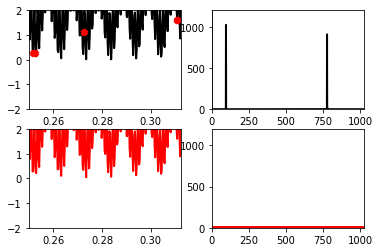

In [52]:
## Plot
time_window = np.array([1024,1280])/4096
freq = np.arange(n)
L = int(np.floor(n/2))


fig,axs = plt.subplots(2,2)
axs = axs.reshape(-1)

axs[1].plot(freq[:L],PSD[:L],color='k',linewidth=2)
axs[1].set_xlim(0, 1024)
axs[1].set_ylim(0, 1200)

axs[0].plot(t,x,color='k',linewidth=2)
axs[0].plot(perm/n,y,color='r',marker='x',linewidth=0,ms=5,mew=4)
axs[0].set_xlim(time_window[0],time_window[1])
axs[0].set_ylim(-2, 2)

axs[2].plot(t,xrecon,color='r',linewidth=2)
axs[2].set_xlim(time_window[0],time_window[1])
axs[2].set_ylim(-2, 2)

xtrecon = np.fft.fft(xrecon,n) # computes the (fast) discrete fourier transform
PSDrecon = xtrecon * np.conj(xtrecon)/n # Power spectrum (how much power in each freq)

axs[3].plot(freq[:L],PSDrecon[:L],color='r',linewidth=2)
axs[3].set_xlim(0, 1024)
axs[3].set_ylim(0, 1200)

plt.show()

In [28]:
## L1-Minimization using SciPy
def L1_norm(x):
    return np.linalg.norm(x,ord=1)

constr = ({'type': 'eq', 'fun': lambda x:  Theta @ x - y})
x0 = np.linalg.pinv(Theta) @ y 
res = minimize(L1_norm, x0, method='SLSQP',constraints=constr)
s = res.x
xrecon = idct(s)

In [8]:
print(s)

[-0.00061083  0.00170517 -0.00165844 ...  0.00034396 -0.00308204
 -0.00065701]


In [13]:
Theta.shape

(128, 4096)

In [14]:
y.shape

(128,)

In [58]:
unmitis = []
unmitis_recon = []
# for i in range(4):
data = np.load("figs/cnt_opt_miti/2022-07-23_14:32:44/G31_nQ8_p2/varIdx3.npz", allow_pickle=True)
unmitis = data['unmitis']
unmitis_recon = data['unmitis_recon']
print(unmitis, unmitis_recon)


[5.61767578 6.51464844 3.92578125 ... 8.16552734 5.65673828 4.42578125] [4.2239904  4.22398825 4.22398395 ... 2.0861718  2.0861675  2.08616535]


In [73]:
def draw_PSD(x):
    n = x.shape[0]
    freq = np.arange(n)
    # L = int(np.floor(n/2))
    L = 10

    fig, axs = plt.subplots()
    xt = np.fft.fft(x, n) # computes the (fast) discrete fourier transform
    PSD = xt * np.conj(xt) / n # Power spectrum (how much power in each freq)

    # axs.set_xlim(0, 1024)
    axs.set_ylim(0, 1024)
    axs.plot(freq[1:L], PSD[1:L], color='r', linewidth=2)
    plt.show()

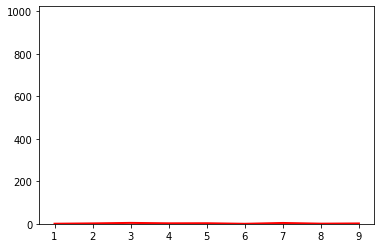

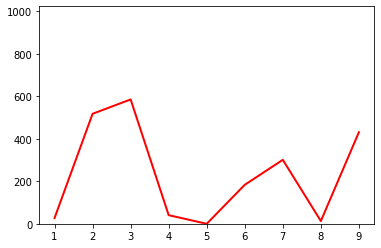

In [74]:
draw_PSD(unmitis)
draw_PSD(unmitis_recon)